<a href="https://colab.research.google.com/github/kimhwijin/TensorflowWithKeras/blob/master/CNN/DeepDream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#https://github.com/google/deepdream
#https://github.com/pukkapies/applied-dl/blob/master/examples/9-deepdream-minimal.ipynb

In [6]:
import numpy as np
import tensorflow as tf

from IPython.display import clear_output
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing import image

In [2]:
#이미지 다운로드 및 Numpy 배열로 변환
def download(url):
  name = url.split("/")[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = image.load_img(image_path)
  return image.img_to_array(img)

#픽셀을 (-1.0, 1.0) 사이의 값으로 조정
def preprocess(img):
  return (img / 127.5) - 1

#픽셀을 (-1.0, 1.0) 사이의 값에서 0 ~ 255 값으로 조정
def deprocess(img):
  img = img.copy()
  img /= 2.0
  img += 0.5
  img *= 255.
  return np.clip(img, 0, 255).astype('uint8')

#이미지 표시
def show(img):
  plt.figure(figsize=(12,12))
  plt.grid(False)
  plt.axis('off')
  plt.imshow(img)

499712/499095 [==============================] - 1s 1us/step


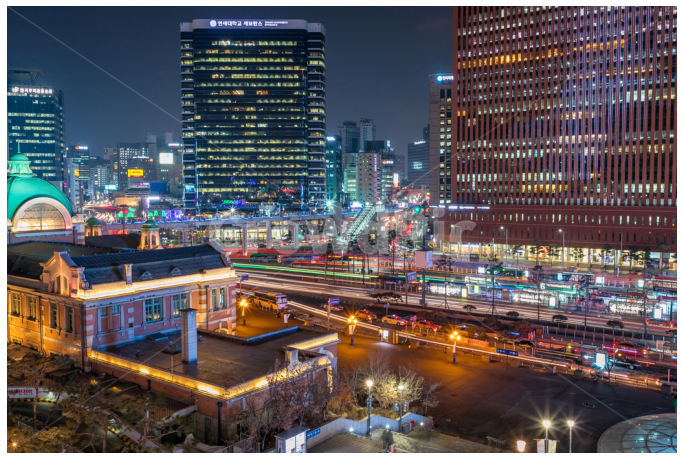

In [5]:
# https://commons.wikimedia.org/wiki/File:Flickr_-_Nicholas_T_-_Big_Sky_(1).jpg
#https://cdn.crowdpic.net/detail-thumb/thumb_d_50662BC64537D8301B469988CF30F97F.jpg
url = 'https://cdn.crowdpic.net/detail-thumb/thumb_d_50662BC64537D8301B469988CF30F97F.jpg'
img = preprocess(download(url))
show(deprocess(img))

In [8]:
inception_v3 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False)

87916544/87910968 [==============================] - 1s 0us/step


In [13]:
#inception 망을 사용
#특정 계층들의 활성화를 최대화
names = ['mixed2','mixed3','mixed4','mixed5']
layers = [inception_v3.get_layer(name).output for name in names]

#특징 추출 모델 생성
feature_extraction_model = tf.keras.Model(inputs=inception_v3.input, outputs=layers)

def forward(img):
  #배치 생성
  img_batch = tf.expand_dims(img, axis=0)
  #이미지를 인셉션을 통해 전방 전달, 앞서 선택한 계층의 활성화 함수 추출
  return feature_extraction_model(img_batch)

In [14]:
def calc_loss(layer_activations):
  total_loss = 0

  for act in layer_activations:
    
    #그래디언트 상승에서는, 이 값을 최대화
    #따라서 이미지는 점진적으로 계층을 '자극'한다.
    loss = tf.math.reduce_mean(act)

    #계층의 유닛 개수로 정규화
    loss /= np.prod(act.shape) #shape[0] * shape[1] ... shape[-1]
    total_loss += loss

  return total_loss

Step 0 loss 0.000001


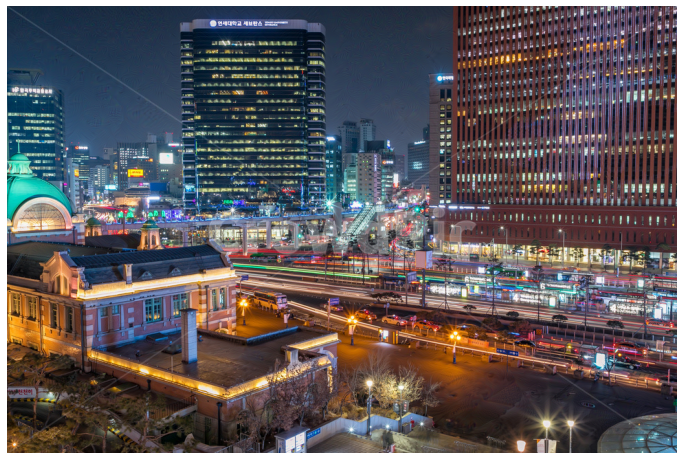

Step 50 loss 0.000001


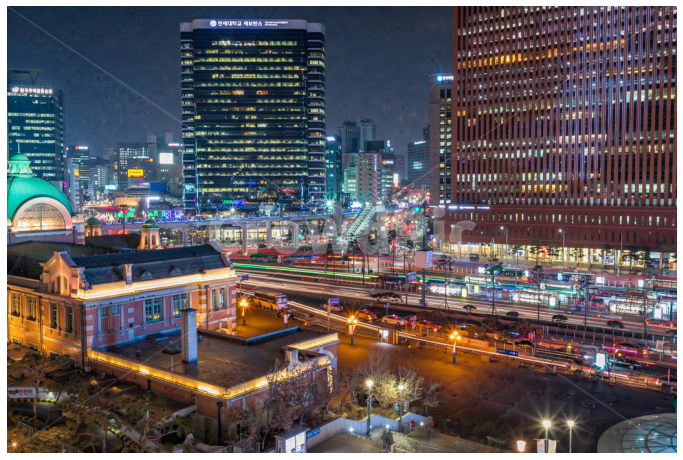

Step 100 loss 0.000001


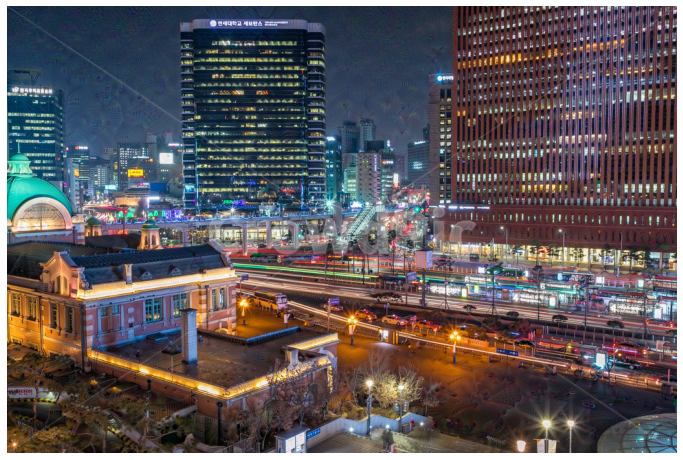

Step 150 loss 0.000001


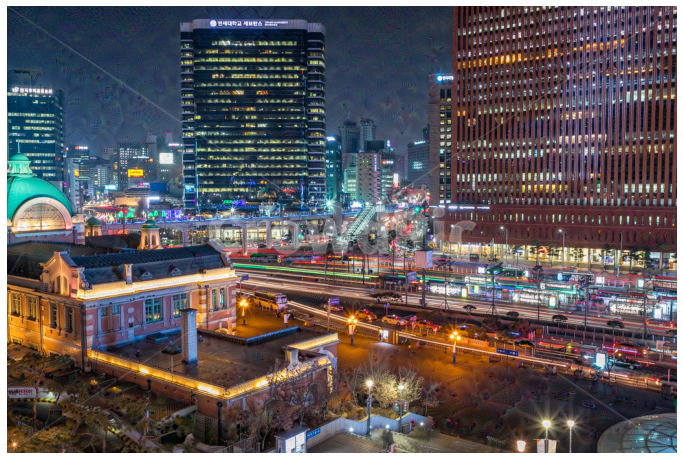

Step 200 loss 0.000001


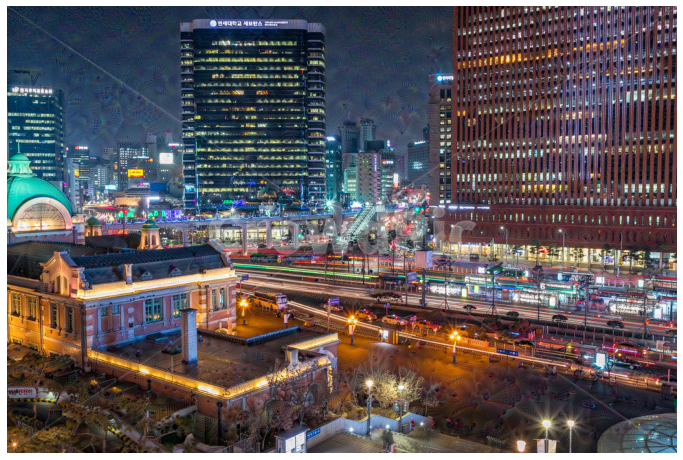

Step 250 loss 0.000001


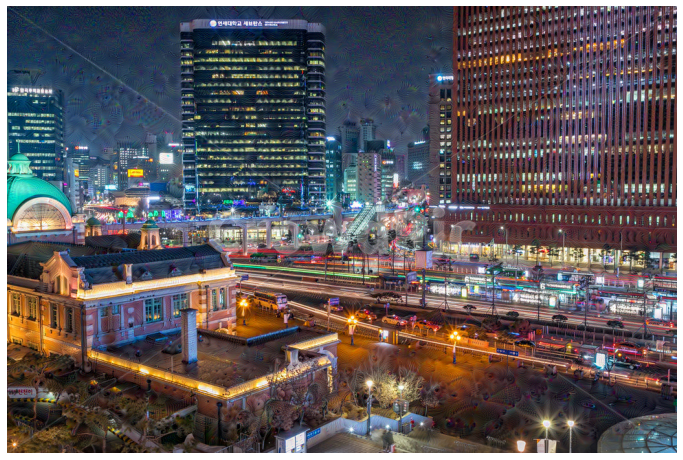

Step 300 loss 0.000001


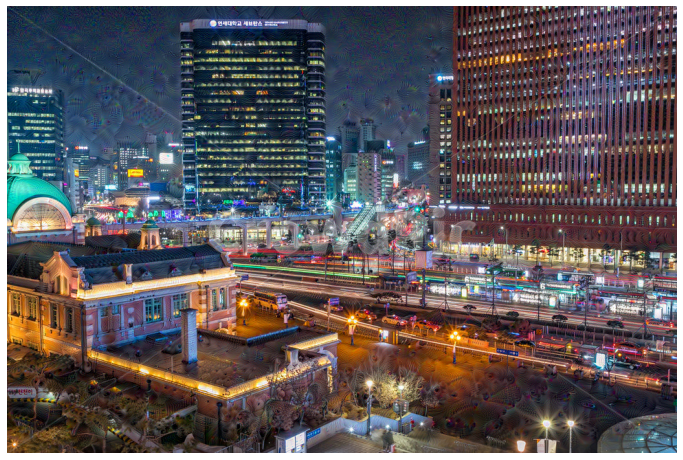

Step 350 loss 0.000001


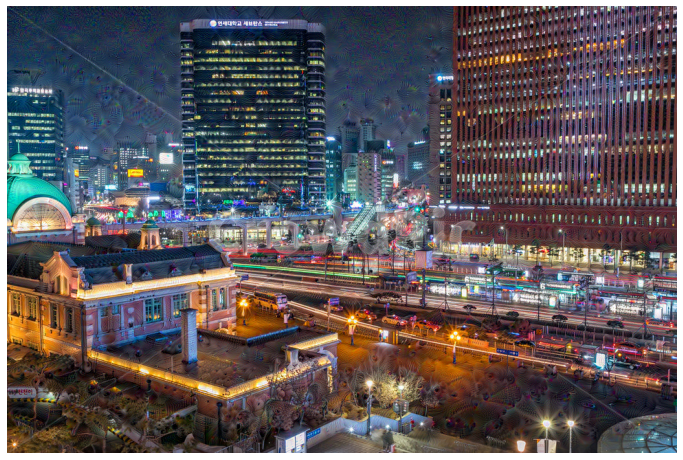

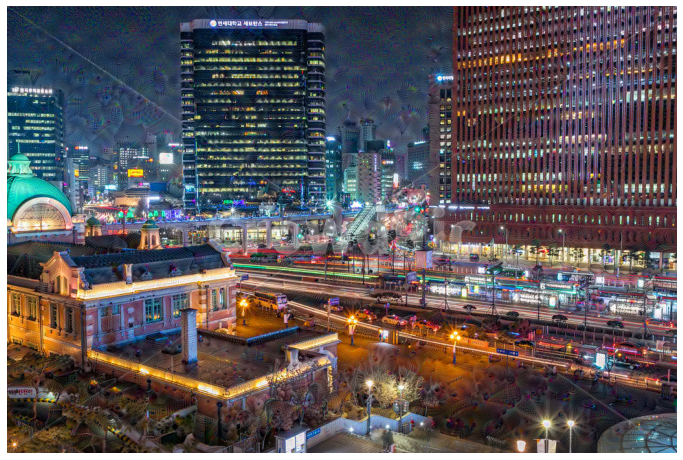

In [16]:
img = tf.Variable(img)
steps = 400

for step in range(steps):
  with tf.GradientTape() as tape:
    activations = forward(img)
    loss = calc_loss(activations)

  gradients = tape.gradient(loss, img)
  #그래디언트 정규화
  gradients /= gradients.numpy().std() + 1e-8

  #그래디언트를 즉시 더해 이미지를 갱신
  img.assign_add(gradients)

  if step % 50 == 0:
    #clear_output()
    print("Step %d loss %f" %(step,loss))
    show(deprocess(img.numpy()))
    plt.show()

#clear_output()
show(deprocess(img.numpy()))